# Case - CNC主軸故障偵測 (FCFT)

Copyright © 2019 Hsu Shih-Chieh  

使用每天早上收集的實驗數據, 但有異常的數據已經遺失, 所以無法驗證異常是否能被偵測


In [8]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import sys, os, datetime, warnings, scipy, collections, random, pywt, time, matplotlib
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from utils import set_font_cn
from utils import Bunch
from datasets import load_fcft
from tqdm.notebook import tqdm
from scipy import signal, stats
from utils import getorderrms_fcft
from sklearn.preprocessing import MinMaxScaler, StandardScaler
set_font_cn()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [2]:
data = load_fcft()
print(data.DESCR)

  0%|          | 0/17 [00:00<?, ?it/s]

  > 讀取sensor數據


100%|██████████| 17/17 [00:30<00:00,  1.81s/it]


CNC FCFT dataset
-------------------

**Data Set Characteristics::**

    :控制器數據欄位:
        - x: X軸機械座標
        - y: y軸機械座標
        - z: z軸機械座標        
        - feed: 設定進給
        - time: Datetime
        - feedtrue: 實際進幾
        - feedrate: 進幾率
        - gcode: 單節
        - sload: 主軸負載
        - speed: 設定轉速
        - cutv: 切削量
        - seedtrue: 實際轉速
        
    :震動傳感器欄位:
        - Spindle_S01: ?軸震動 (X or Y ro Z)
        - Spindle_S02: ?軸震動
        - Spindle_S03: ?軸震動
        - Current_IA: 三相電流
        - Current_IB: 三相電流
        - Current_IC: 三相電流
        
    :數據收集日期
        - 20180430
        - 20180502
        - 20180503
        - 20180508        
    
    
**讀取數據Sample Code**

::
    data = load_fcft()    
    
    
**Preprocess & Featureing**
    
    :數據特徵: 轉速的一階次頻率
    
**Model**
    
    :PCA T2/SPE: 用正常主軸的熱機數據當作基準, 監測後續每天的熱機數據是否發生異常. 
    
專案說明：
CNC的主軸為高單價的設備組件, 所以在每天開工以前都會透過一個熱機過程來檢測主軸是否有異常, 熱機過程如下：主軸不裝刀具, 設定不同轉速, 每個轉速都運轉一段時間並收集震動傳感器數據. 在這個專案我們收集主軸熱機過程數據, 並觀察每一個轉速的一階次頻率是否

### Featuring
    - first order frequency rms

In [3]:

def getorderrms_fcft(data, order):
    speedhz=2000#/60
    fs=25600
    nperseg=2560
    f, Pxx_den = signal.welch(data, fs, window='hanning', nperseg=nperseg, scaling='density')
    rmslist=[]
    f_H_idx = np.where(f>=(speedhz*order))[0][0]
    f_L_idx = np.where(f<=(speedhz*order))[0][-1]
    rms = getrms(Pxx_den[f_L_idx-3:f_H_idx+3] )
    return rms

In [4]:
firstorders = Bunch()
for key in tqdm(data.keys()):
    if not key.endswith('rpm'):
        continue
    d = data[key] 
    d = d.set_index('time') 
    order = d.resample('3s').apply(getorderrms_fcft, order=1) 
    order=order.dropna()
    firstorders[key]= order

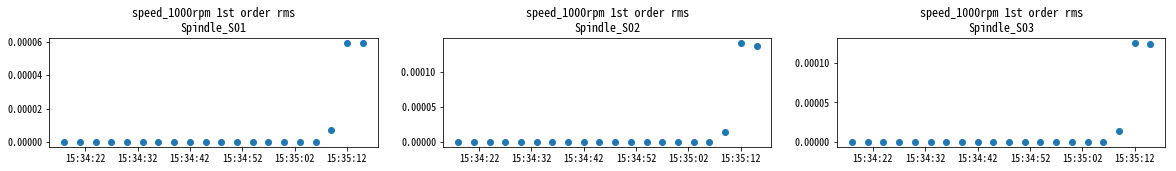

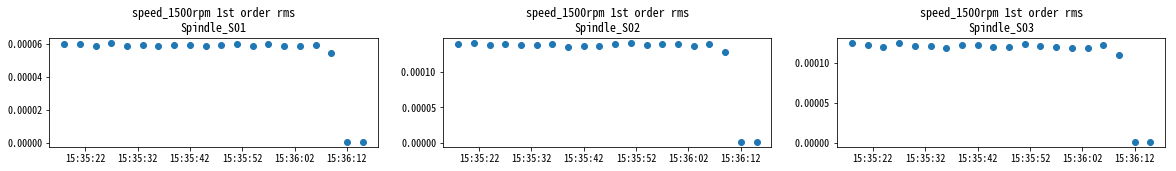

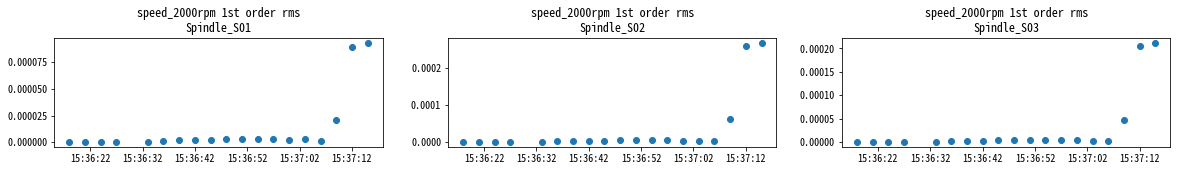

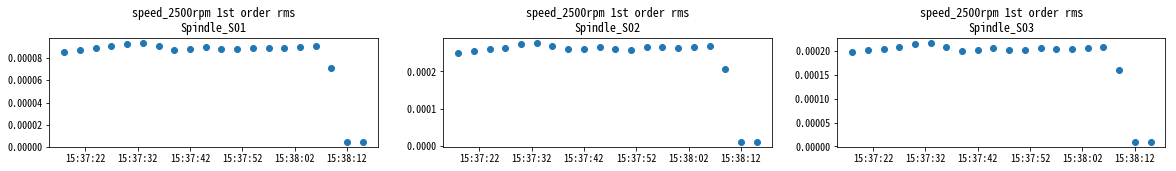

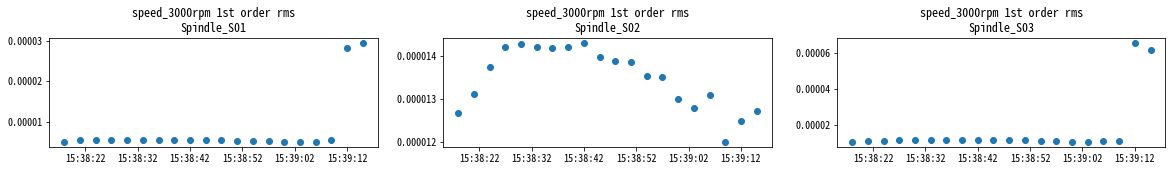

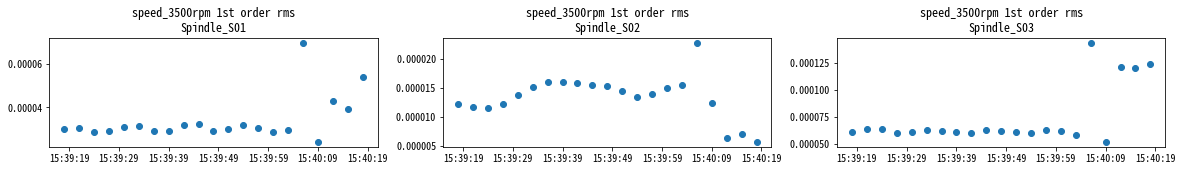

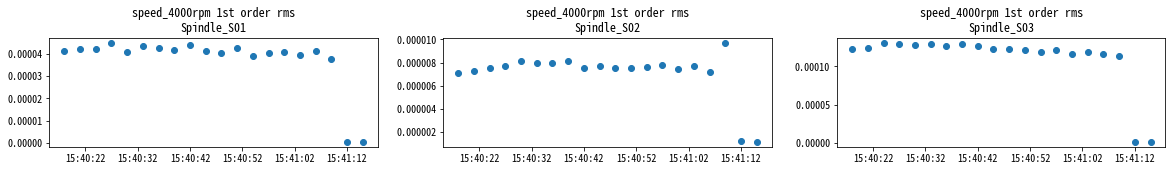

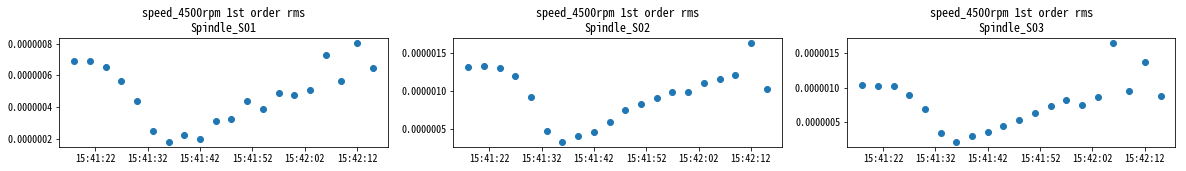

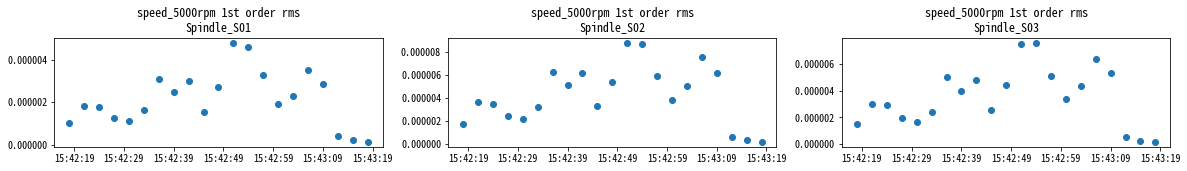

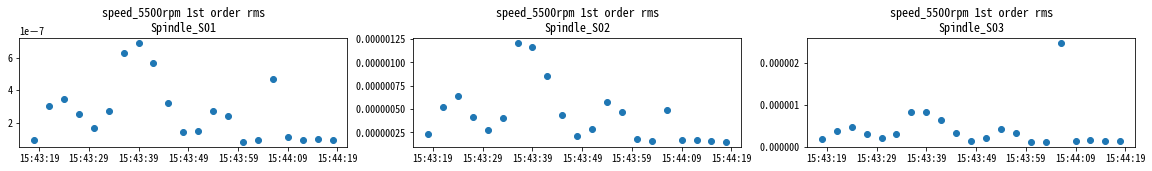

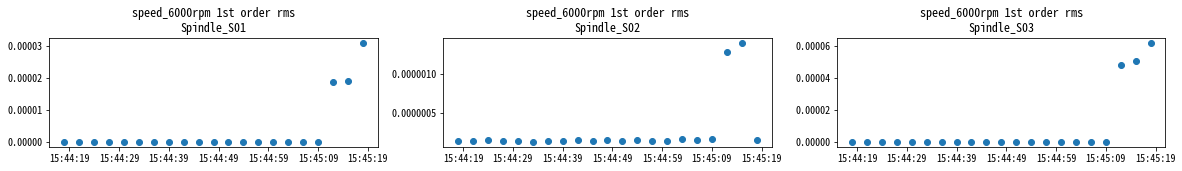

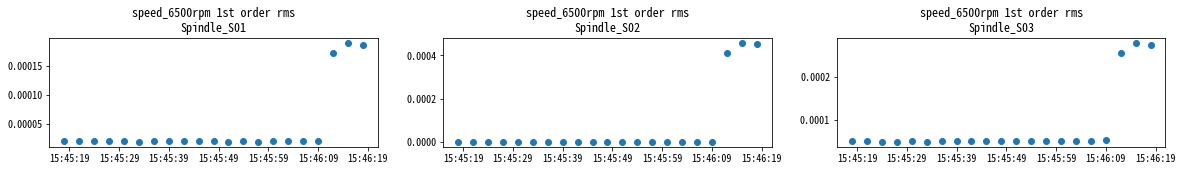

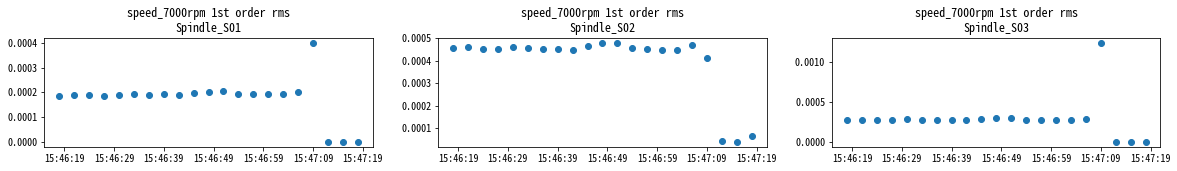

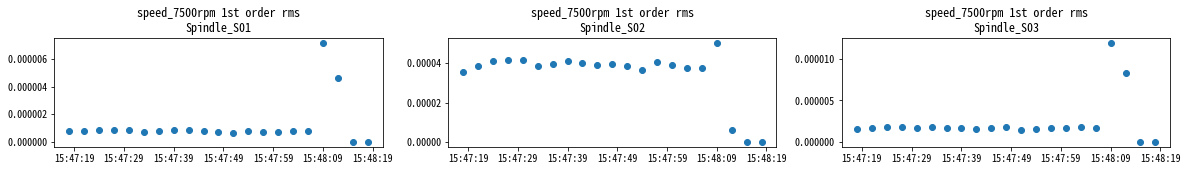

In [5]:
for key in firstorders.keys():
    plt.figure(figsize=(20,2))
    for k,v in enumerate(['Spindle_S01','Spindle_S02','Spindle_S03']):
        plt.subplot(131+k)
        d = firstorders[key]
        plt.plot(d.index, d[v].values,'o')
        plt.title(f'{key} 1st order rms\n{v}')
    plt.show()



### Modeling 
PCA T2/SPE

引入異常的實驗數據遺失, 無法實作